# Tutorial 1 - Classification

In this tutorial, we will first revisit a logistic-regression like approach for the MNIST classification task. This time we will be using PyTorch and PyTorch Lightning for the implementation, training, and testing. The task is then two replace the single-layer neural network with a convolutional neural network such as LeNet. We will compare the performance of the approaches on an out-of-distribution test set where digits have been slightly shifted.

**Objective:** Use PyTorch and PyTorch Lightning for the development of deep neural networks for image classification.

In [1]:
# On Google Colab uncomment the following line to install PyTorch Lightning
! pip install lightning

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import accuracy

## Data

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling the MNIST dataset.

In [3]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = './data', batch_size: int = 32, num_workers: int = 4, transform = transforms.ToTensor()):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform        

        self.test_set = MNIST(self.data_dir, train=False, transform=self.transform, download=True)
        dev_set = MNIST(self.data_dir, train=True, transform=self.transform, download=True)
        self.train_set, self.val_set = random_split(dev_set, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

## Model

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**Task:** Replace the single-layer network with a LeNet-like CNN architecture. You need to add the model layers and change the forward pass accordingly.

In [10]:
class ImageClassifier(LightningModule):
    def __init__(self, input_dim: tuple[int, int] = (28,28), output_dim: int = 10, learning_rate: float = 0.001):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # single-layer network (logistic regression-like)
        #self.fc_layer = nn.Linear(torch.prod(torch.tensor(self.input_dim)), self.output_dim)

        #LeNet like network
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Assuming input images are 32x32
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Assuming 10 classes


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def process_batch(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=self.output_dim)
        
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch[0][0:16, ...], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_batch(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)

## Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for training and testing.

In [11]:
seed_everything(42, workers=True)

data = MNISTDataModule(data_dir='./data', batch_size=32)

model = ImageClassifier(input_dim=(28,28), output_dim=10, learning_rate=0.001)

trainer = Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/classification/', name='mnist-logreg'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2.4 K 
2 | fc1   | Linear | 30.8 K
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 850   
---------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1719/1719 [00:25<00:00, 68.64it/s, v_num=3, train_loss=0.00131, train_acc=1.000, val_loss=0.0412, val_acc=0.990] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1719/1719 [00:25<00:00, 68.64it/s, v_num=3, train_loss=0.00131, train_acc=1.000, val_loss=0.0412, val_acc=0.990]


## Validation

Evaluate the trained model with the best checkpoint on the validation data and report the classification accuracy.

In [12]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 155.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9886000156402588
        val_loss            0.04106861725449562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.04106861725449562, 'val_acc': 0.9886000156402588}]

## Testing

Evaluate the trained model with the best checkpoint on the test data and report the classification accuracy.

In [13]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 111.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9911999702453613
        test_loss           0.03059040755033493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03059040755033493, 'test_acc': 0.9911999702453613}]

## Testing on out-of-distribution data

Here we prepare an out-of-distribution test set where all digits are shifted by two pixels. We then test the trained model and report the classification accuracy.

In [14]:
transform = transforms.Compose([
    transforms.CenterCrop((26,26)),
    transforms.Pad((0,0,2,2)),
    transforms.ToTensor()
])

data_ood = MNISTDataModule(data_dir='./data', batch_size=32, transform=transform)

trainer.test(model=model, datamodule=data_ood, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-logreg/version_3/checkpoints/epoch=7-step=13752.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 148.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9627000093460083
        test_loss           0.1297653615474701
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1297653615474701, 'test_acc': 0.9627000093460083}]

## Visualisation

### Test data examples

Let's compare the original, in-distribution and the out-of-distribution test data.

Text(0.5, 1.0, 'difference')

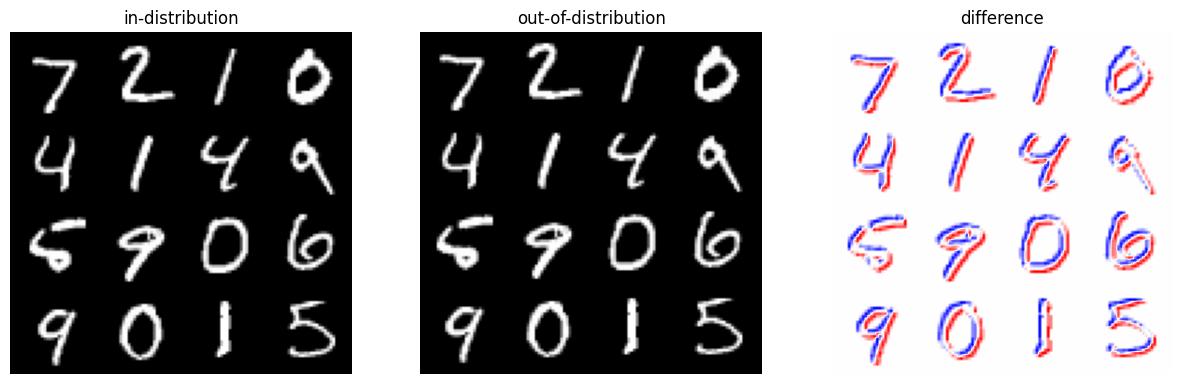

In [15]:
samples_iid = [data.test_set[i][0] for i in range(0,16)]
samples_ood = [data_ood.test_set[i][0] for i in range(0,16)]
grid_iid = torchvision.utils.make_grid(samples_iid, nrow=4, normalize=True).numpy()[0,...].squeeze()
grid_ood = torchvision.utils.make_grid(samples_ood, nrow=4, normalize=True).numpy()[0,...].squeeze()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(grid_iid, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('in-distribution')

ax[1].imshow(grid_ood, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('out-of-distribution')

ax[2].imshow(grid_iid - grid_ood, cmap=matplotlib.cm.bwr)
ax[2].axis('off')
ax[2].set_title('difference')

### Weights

Let's inspect the patterns that the single-layer network has learned for each digit class.

In [20]:
weights = model.fc_layer.weight.detach().cpu().numpy()

f, ax = plt.subplots(1,10, figsize=(15, 15))

for i in range(0,10):
    vmax = np.max(np.abs(weights[i,:])) / 2
    ax[i].imshow(weights[i,:].reshape(28,28), cmap=matplotlib.cm.bwr, clim=(-vmax,vmax))
    ax[i].axis('off')

AttributeError: 'ImageClassifier' object has no attribute 'fc_layer'

## Logging

In [21]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/classification/'